# Package example usages

In this demo we will show how to use the `deepskin` package to perform the analysis of a wound image.
The proposed analysis will show the main features of the `deepskin` package, showing the performances of the proposed models and the issues still opened.

For the image management we will use the `OpenCV` python packages combined with the classical `Numpy` library.
Analogous results could be easily obtained changing these dependencies according to your needs.

First of all, we need to import an image (typically acquired by a smartphone camera).

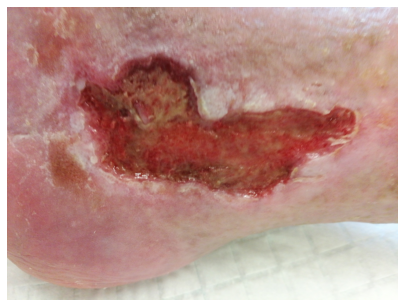

In [1]:
import cv2
import pylab as plt

# define the image filename
filename = 'image.png'
# load the image using OpenCV library
img = cv2.imread(filename)
# convert the image to RGB fmt for the display
img = img[..., ::-1]

# define the plot figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
canvas = ax.imshow(img)
_ = ax.axis('off')

This image shows a classical picture sampled during the clinical practice.
The image was acquired without a rigid standardization of the light or any other constraint.
Using the `deepskin` package we can easily obtain the wound segmentation mask which identifies the image ROI on which focus our analysis.

**⚠️ Note:** with the novel version of the deepskin package, we can easily obtain a multi-class segmentation mask, providing information also about the patient body ROI.
The combination of these information could further improve the identification of the peri-wound area!

Perform the semantic image segmentation...  [DONE] (8.079 sec)                  


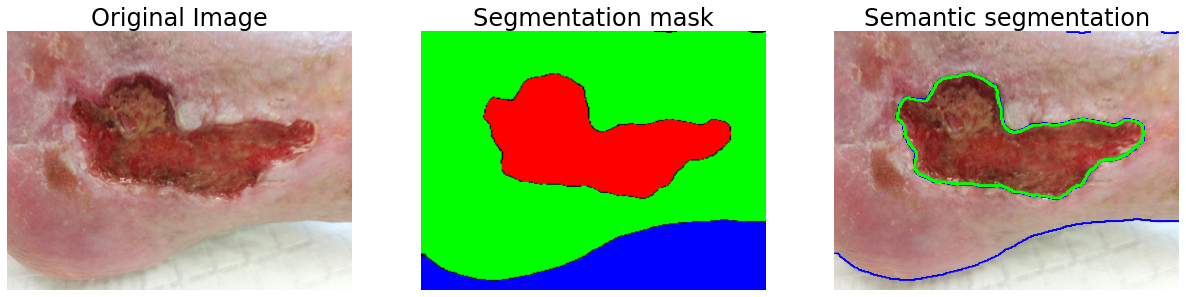

In [2]:
import cv2
from deepskin import wound_segmentation

# get the wound segmentation mask
segmentation = wound_segmentation(
    img=img,
    tol=0.95,
    verbose=True,
)

wound_mask, body_mask, bg_mask = cv2.split(segmentation)

# display the results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=24)
_ = ax1.axis('off')
ax2.imshow(segmentation)
ax2.set_title('Segmentation mask', fontsize=24)
_ = ax2.axis('off')
ax3.imshow(img)
ax3.contour(body_mask, colors='blue', linewidths=1)
ax3.contour(wound_mask, colors='lime', linewidths=2)
ax3.set_title('Semantic segmentation', fontsize=24)
_ = ax3.axis('off')

The information captured by the semantic segmentation could be used to focus the image processing algorithms on the relevant portion of the image.
An example is given by the detection of the peri-wound area of the picture, which could be obtained by a combination of erosion/dilation of the detected wound ROI.
To better refine the peri-wound area, we can use the body-mask ROI to filter spurious parts obtained by morphological operations.
An example is given below:

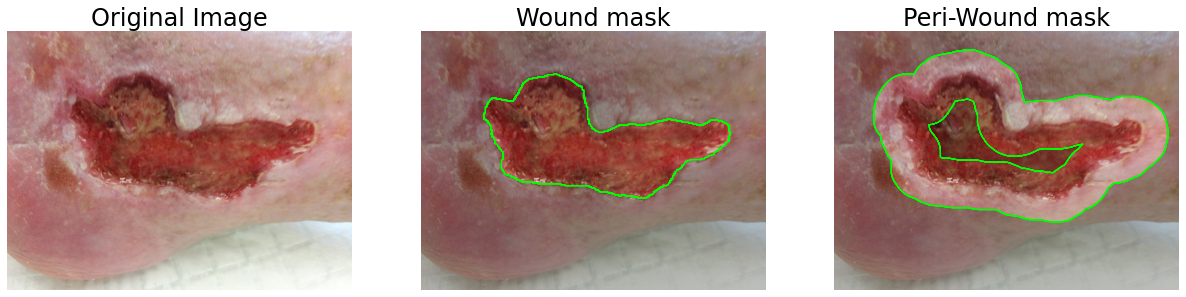

In [3]:
from deepskin.imgproc import imfill
from deepskin.imgproc import get_perilesion_mask

# compute the peri-wound mask
peri_wound_mask = get_perilesion_mask(mask=wound_mask, ksize=(200, 200))
# refine it using the body-mask ROI
peri_wound_mask = cv2.bitwise_and(
    peri_wound_mask,
    peri_wound_mask,
    mask=imfill(body_mask | wound_mask) # correct the body mask
)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=24)
_ = ax1.axis('off')
wound_masked = cv2.bitwise_and(img, img, mask=wound_mask)
ax2.imshow(wound_masked)
ax2.imshow(img, alpha=0.75)
ax2.contour(wound_mask, colors='lime', linewidths=1)
ax2.set_title('Wound mask', fontsize=24)
_ = ax2.axis('off')
peri_wound_masked = cv2.bitwise_and(img, img, mask=peri_wound_mask)
ax3.imshow(peri_wound_masked)
ax3.imshow(img, alpha=0.75)
ax3.contour(peri_wound_mask, colors='lime', linewidths=1)
ax3.set_title('Peri-Wound mask', fontsize=24)
_ = ax3.axis('off')

Now using the obtained masks, we can extract a series of informative features for the redness estimation and the morphological aspect of the wound/peri-wound ROIs.
All these features could be easily obtained by the `deepskin` package, which provides also a ready-to-use function for the estimation of the PWAT score.

The above image, indeed, was labeled by the expert clinicians as a wound with a `PWAT=12`.
Using the `deepskin` PWAT estimator we could obtain a finer evaluation of the PWAT score, using the output of a regressor model.

Perform the PWAT estimation...  [DONE]  (1.741 sec)                              


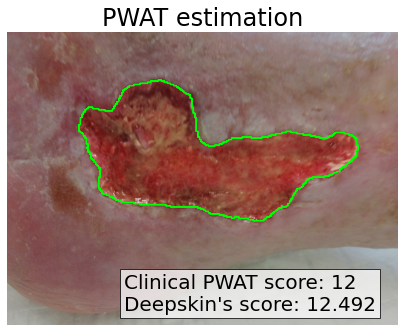

In [6]:
from deepskin import evaluate_PWAT_score

# compute the PWAT score using the regression model
pwat = evaluate_PWAT_score(
    img=img, 
    mask=segmentation, 
    ksize=(200, 200),
    verbose=True
)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
ax.imshow(wound_masked)
ax.imshow(img, alpha=0.75)
ax.contour(wound_mask, colors='lime', linewidths=1)
ax.set_title('PWAT estimation', fontsize=24)
t = ax.text(0.3, 0.05, f"Clinical PWAT score: 12\nDeepskin's score: {pwat:.3f}",
            transform=ax.transAxes, fontsize=20)
t.set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='k'))
_ = ax.axis('off')

As expected the estimation of the PWAT score is not perfect and it could differ from the ground-truth.
However, the prediction is still compatible with the real one, providing a valid alternative to the clinical evaluation.

**⚠️ Note**:
We would stress that the provided model **is intended for clinical use** and the output could suffer by the dataset used for the training and/or by the quality of the image.

For sake of completeness, we report the entire pipeline of processing for the PWAT estimation on a series of images, for a faster manual evaluation of the possible pros and cons of the described model.

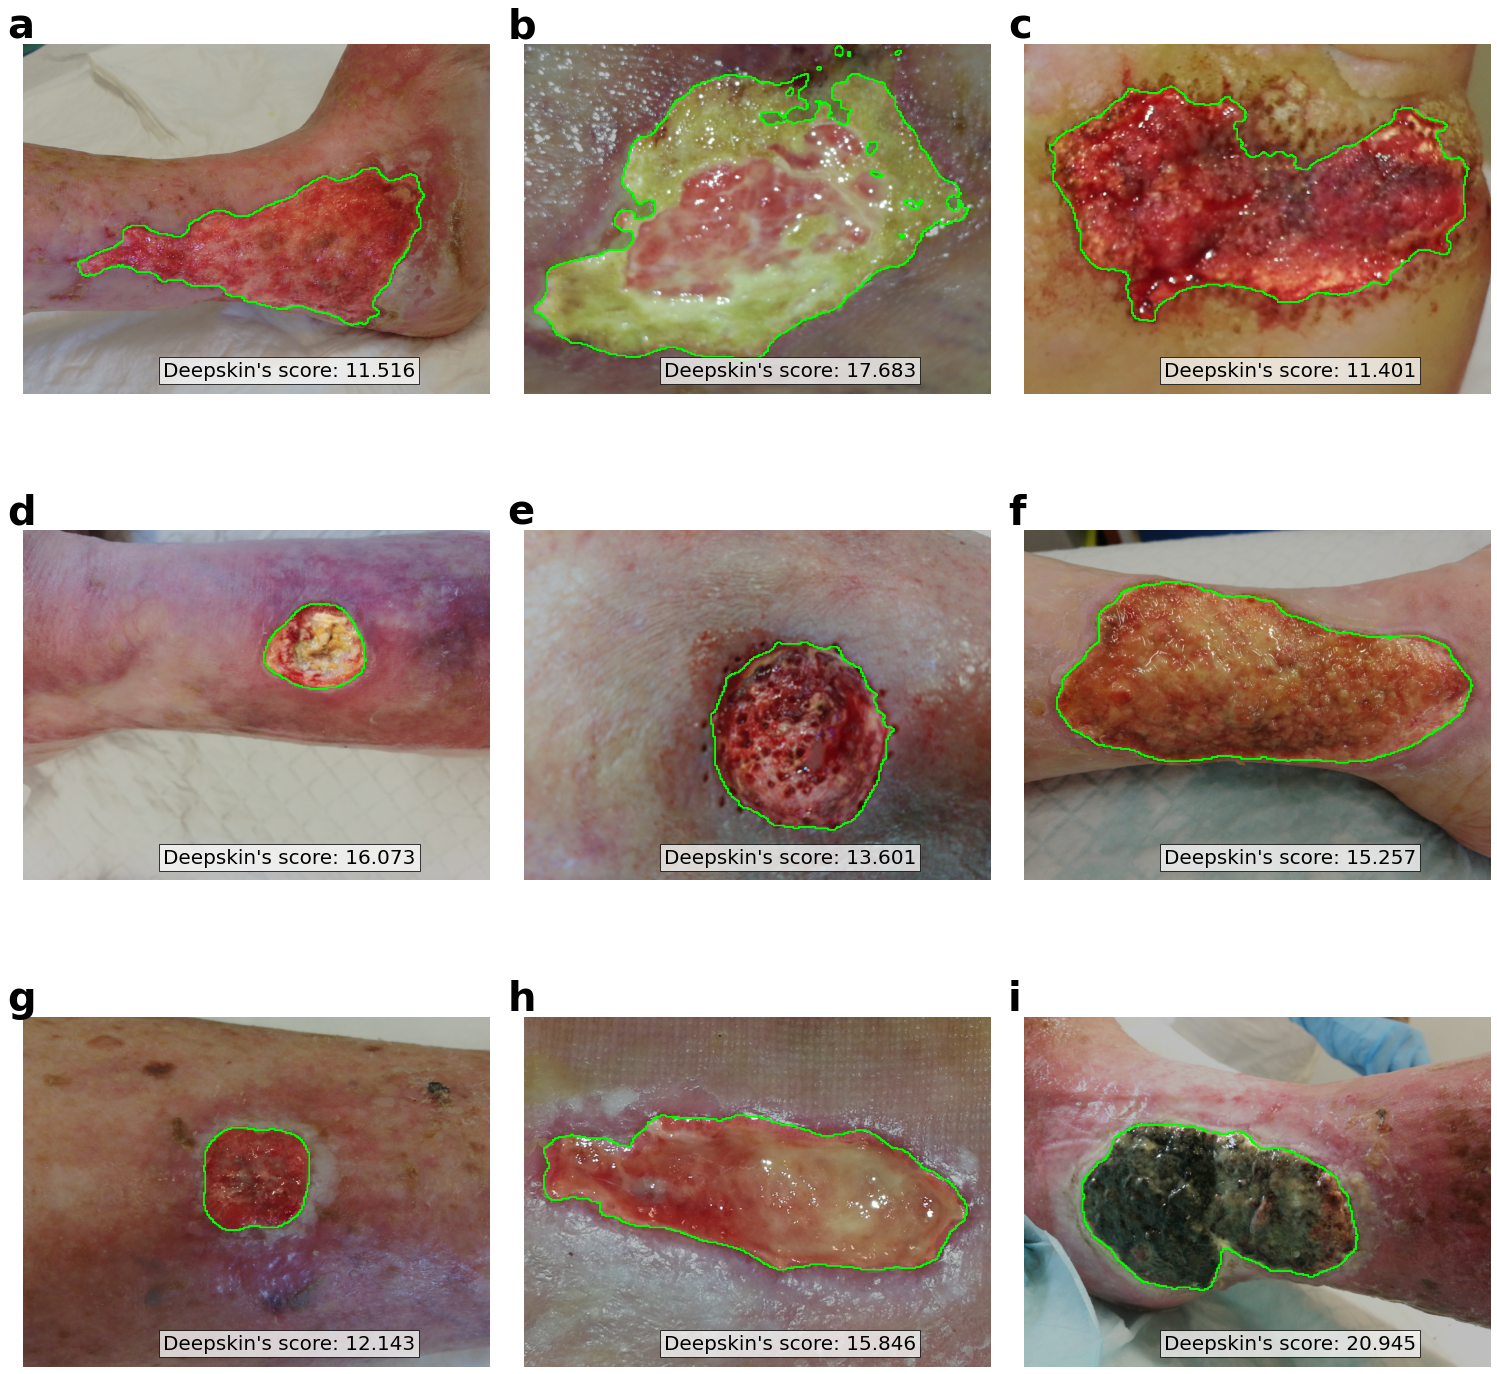

In [11]:
from glob import glob

files = glob('./test_images/*.png')
label = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(21, 21))

for f, ax, lbl in zip(files, axes.ravel(), label):
    
    # load the image in RGB fmt
    img = cv2.imread(f)[..., ::-1]
    
    # get the semantic segmentation mask
    mask = wound_segmentation(
      img=img,
      tol=0.5,
      verbose=False,
    )
    # un-pack the semantic mask
    wound_mask, body_mask, bg_mask = cv2.split(mask)
    
    # compute the wound PWAT
    pwat = evaluate_PWAT_score(
      img=img,
      mask=mask,
      verbose=False,
    )
    # mask the image according to the wound
    wound_masked = cv2.bitwise_and(
        img, 
        img, 
        mask=wound_mask
    )
    
    # display the result
    ax.imshow(wound_masked)
    ax.imshow(img, alpha=0.75)
    ax.contour(wound_mask, colors='lime', linewidths=1)
    
    ax.text(-50, -20, lbl, fontsize=40, color='k', weight='bold')
    t = ax.text(0.3, 0.05, f"Deepskin's score: {pwat:.3f}",
                transform=ax.transAxes, fontsize=20)
    t.set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='k'))
    _ = ax.axis('off')
    
fig.tight_layout()

The results obtained above show how the model could fail in the segmentation of the wound area, mainly due to a still not-perfect training of the semantic segmentation model (ref. Figure **b**).
However, in the majority of the analyzed cases, the wound identification appears reasonably good for further analyses.

The considered images were not labeled by expert clinicians in terms of PWAT score, so the reported values are determined only by the deepskin model.
However, we can conclude that the correcteness of the PWAT estimation relies on the goodness of the semantic segmentation.